In [62]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.decomposition import PCA
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

from shared_decoding.utils.ibl_data_utils import seed_everything
from shared_decoding.utils.ibl_data_loaders import SingleSessionDataModule
from shared_decoding.models.neural_models import eval_model

seed_everything(0)

In [176]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

eids = [fname.split('.')[0] for fname in os.listdir(data_dir) if fname.endswith('npz')]
print(eids)

['5ec72172-3901-4771-8777-6e9490ca51fc', 'd32876dd-8303-4720-8e7e-20678dc2fd71', '03d9a098-07bf-4765-88b7-85f8d8f620cc', '3f859b5c-e73a-4044-b49e-34bb81e96715', '8c33abef-3d3e-4d42-9f27-445e9def08f9', '12dc8b34-b18e-4cdd-90a9-da134a9be79c', 'cc45c568-c3b9-4f74-836e-c87762e898c8']


In [175]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})

In [197]:
import numba

def behavior_decomp(eid, target, model, model_class, data_dir, decomp_type='PCA'):

    DEVICE = torch.device('cpu')

    config = {
        'data_dir': data_dir,
        'temporal_rank': 5,
        'weight_decay': 1e-1,
        'learning_rate': 1e-2,
        'batch_size': 8,
        'eid': eid,
        'imposter_id': None,
        'target': target,
        'lstm_hidden_size': 32,
        'lstm_n_layers': 3,
        'mlp_hidden_size': (256, 128, 64),
        'drop_out': 0.,
        'lr_factor': 0.1,
        'lr_patience': 5,
        'device': DEVICE,
        'n_workers': os.cpu_count()
    }

    dm = SingleSessionDataModule(config)
    dm.setup()

    train_y = []
    for (x, y) in dm.train:
        train_y.append(y.cpu())
    train_y = torch.stack(train_y)
    
    val_y = []
    for (x, y) in dm.val:
        val_y.append(y.cpu())
    val_y = np.stack(val_y)
    
    test_y = []
    for (x, y) in dm.test:
        test_y.append(y.cpu())
    test_y = np.stack(test_y)

    all_y = np.vstack([train_y, val_y, test_y])

    r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type=model_class, plot=False)

    # PCA 
    if decomp_type == 'PCA':
        pca = PCA(n_components=config['n_t_steps'])
        pca.fit(all_y.reshape((-1, config['n_t_steps'])))
        pca_basis = pca.components_
        pca_var_explained = pca.explained_variance_ratio_
    
        signal_decomp = (pca_basis @ test_y.transpose()).var(-1)
        recon_decomp = (pca_basis @ test_pred.transpose()).var(-1)
        error_decomp = (pca_basis @ (test_pred - test_y).transpose()).var(-1)
        return signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y

    # Fourier
    if decomp_type == 'Fourier':

        @numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
        def norm(x):
            return x.real**2 + x.imag**2
        
        def fourier_decomp(data, config, delta_t=20):
            N = config['n_t_steps']
            delta_t = 20 # ms
            sampling_rate = 2*config['n_t_steps']*delta_t
            freq = np.abs(fftfreq(N, d=1/sampling_rate))
            fft_coef = fft(data)
            decomp = []
            for f in np.unique(freq):
                sp = 0
                for idx in np.argwhere(freq == f):
                    sp += norm(fft_coef[:,idx]).mean()
                decomp.append(np.mean(sp))
            decomp = np.array(decomp)
            return decomp

        signal_decomp = fourier_decomp(test_y, config, delta_t=20)
        recon_decomp = fourier_decomp(test_pred, config, delta_t=20)
        error_decomp = fourier_decomp(test_pred - test_y, config, delta_t=20)
        return signal_decomp, recon_decomp, error_decomp, _, r2, test_pred, test_y


##### PCA Behavior Decomposition

In [179]:
eid = eids[0]
target = 'wheel_speed'

In [189]:
signal_decomp, recon_decomp, error_decomp, pca_var_explained = behavior_decomp(
    eids[0], target=target, 
    model=model, model_class='ridge', data_dir=data_dir, decomp_type='PCA'
)

spike data shape: (928, 50, 852)
behavior data shape: (928, 50)


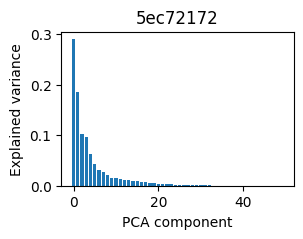

In [190]:
plt.figure(figsize=(3,2))
plt.bar(np.arange(len(pca_var_explained)), pca_var_explained)
plt.title(f'{eid[:8]}')
plt.xlabel('PCA component')
plt.ylabel('Explained variance');

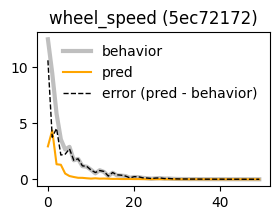

In [191]:
plt.figure(figsize=(3,2))
plt.plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='behavior')
plt.plot(recon_decomp, c='orange', linewidth=1.5, alpha=1., label='pred')
plt.plot(error_decomp, c='k', linewidth=1, alpha=1., linestyle='--', label='error (pred - behavior)')
plt.title(f'{target} ({eid[:8]})')
plt.legend(frameon=False);

##### Fourier Behavior Decomposition

In [184]:
signal_decomp, recon_decomp, error_decomp, pca_var_explained = behavior_decomp(
    eids[0], target=target, 
    model=model, model_class='ridge', data_dir=data_dir, decomp_type='Fourier'
)

spike data shape: (928, 50, 852)
behavior data shape: (928, 50)


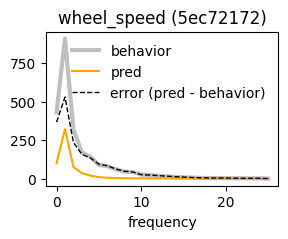

In [187]:
plt.figure(figsize=(3,2))
plt.plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='behavior')
plt.plot(recon_decomp, c='orange', linewidth=1.5, alpha=1., label='pred')
plt.plot(error_decomp, c='k', linewidth=1, alpha=1., linestyle='--', label='error (pred - behavior)')
plt.title(f'{target} ({eid[:8]})')
plt.xlabel('frequency')
plt.legend(frameon=False);

spike data shape: (928, 50, 852)
behavior data shape: (928, 50)
spike data shape: (928, 50, 852)
behavior data shape: (928, 50)
spike data shape: (411, 50, 408)
behavior data shape: (411, 50)
spike data shape: (411, 50, 408)
behavior data shape: (411, 50)
spike data shape: (569, 50, 531)
behavior data shape: (569, 50)
spike data shape: (569, 50, 531)
behavior data shape: (569, 50)
spike data shape: (489, 50, 1839)
behavior data shape: (489, 50)
spike data shape: (489, 50, 1839)
behavior data shape: (489, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (824, 50, 245)
behavior data shape: (824, 50)
spike data shape: (824, 50, 245)
behavior data shape: (824, 50)
spike data shape: (713, 50, 2263)
behavior data shape: (713, 50)
spike data shape: (713, 50, 2263)
behavior data shape: (713, 50)


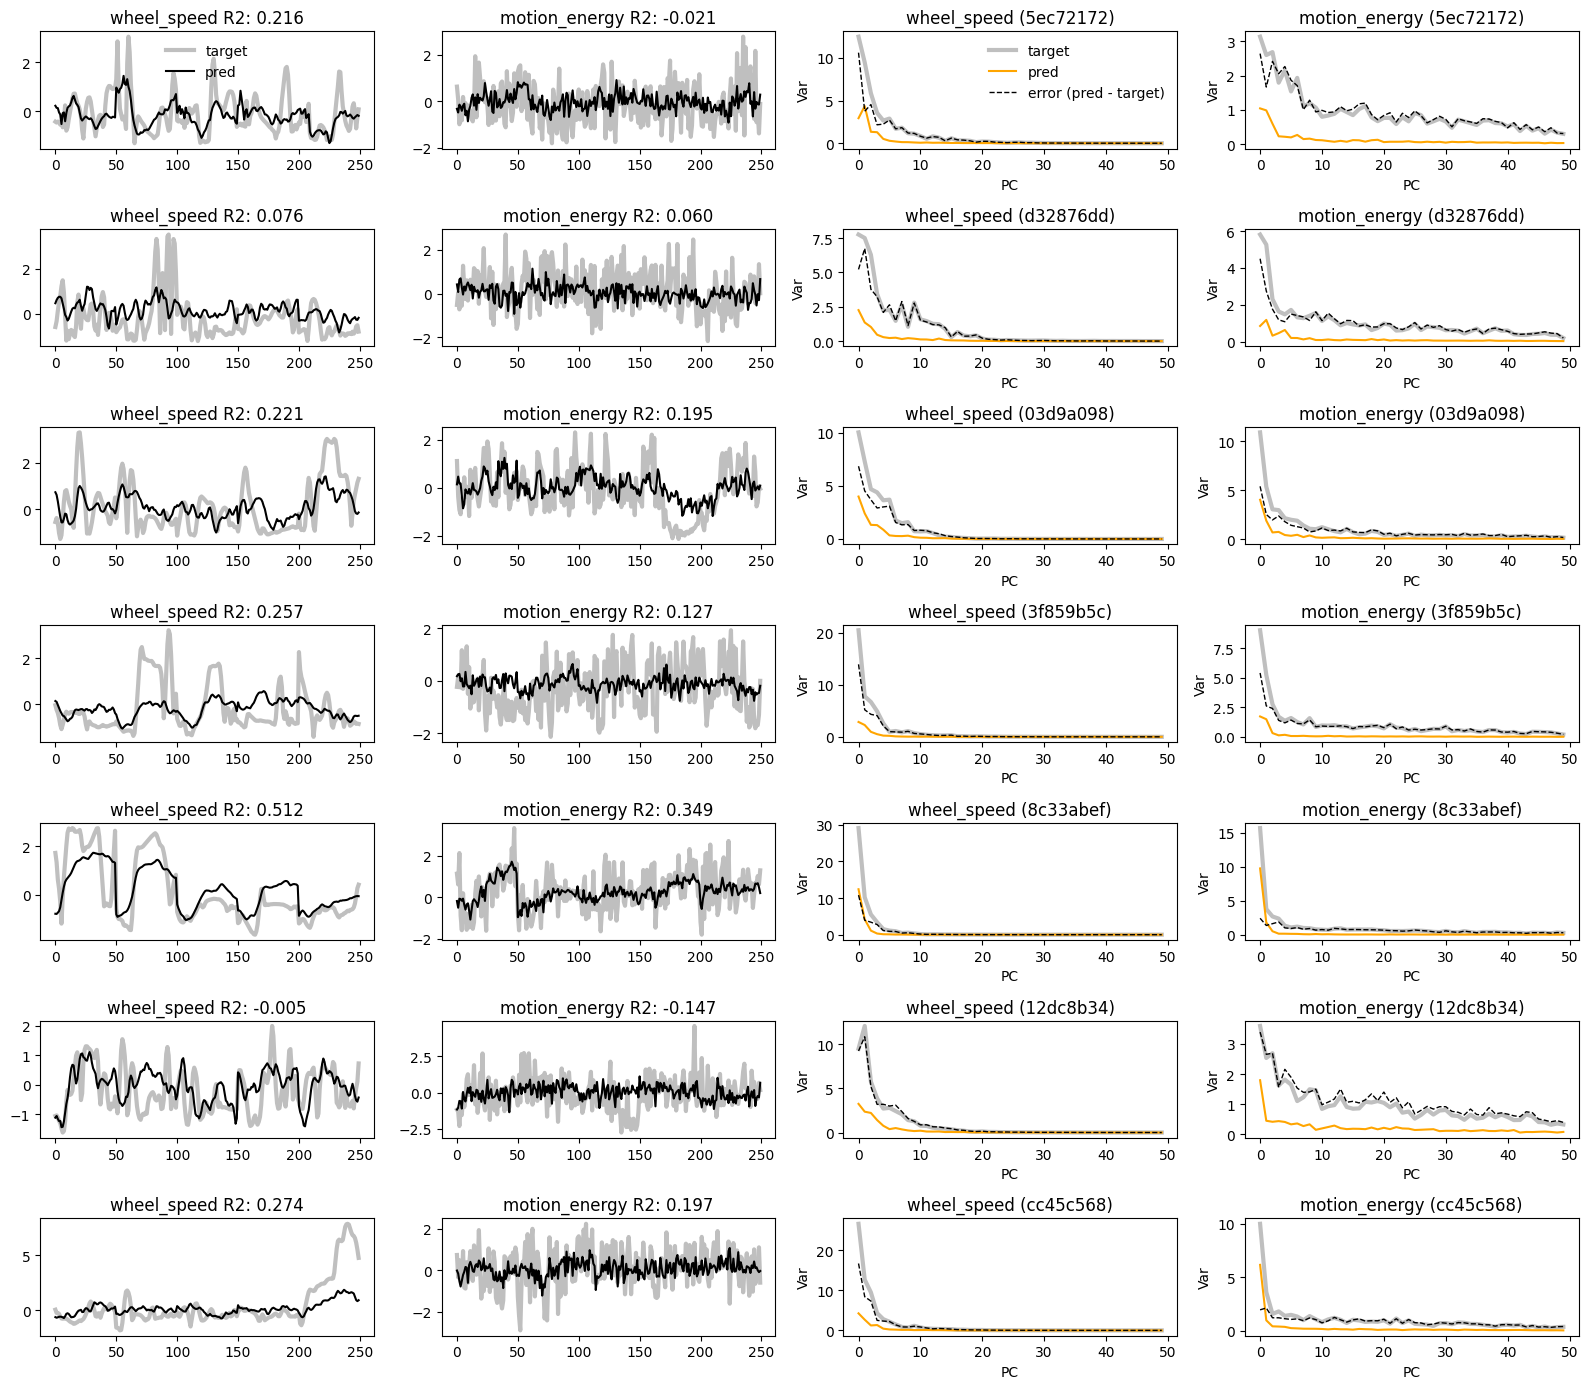

In [202]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+2, figsize=(4*len(targets)*2, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='PCA'
        )
        axes[i,j].plot(test_y[:5].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:5].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('PC')
        axes[i,j+2].set_ylabel('Var')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)
            
plt.tight_layout()
plt.savefig('../results/plots/pca_behavior_decomp.png', dpi=200)

spike data shape: (928, 50, 852)
behavior data shape: (928, 50)
spike data shape: (928, 50, 852)
behavior data shape: (928, 50)
spike data shape: (411, 50, 408)
behavior data shape: (411, 50)
spike data shape: (411, 50, 408)
behavior data shape: (411, 50)
spike data shape: (569, 50, 531)
behavior data shape: (569, 50)
spike data shape: (569, 50, 531)
behavior data shape: (569, 50)
spike data shape: (489, 50, 1839)
behavior data shape: (489, 50)
spike data shape: (489, 50, 1839)
behavior data shape: (489, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (824, 50, 245)
behavior data shape: (824, 50)
spike data shape: (824, 50, 245)
behavior data shape: (824, 50)
spike data shape: (713, 50, 2263)
behavior data shape: (713, 50)
spike data shape: (713, 50, 2263)
behavior data shape: (713, 50)


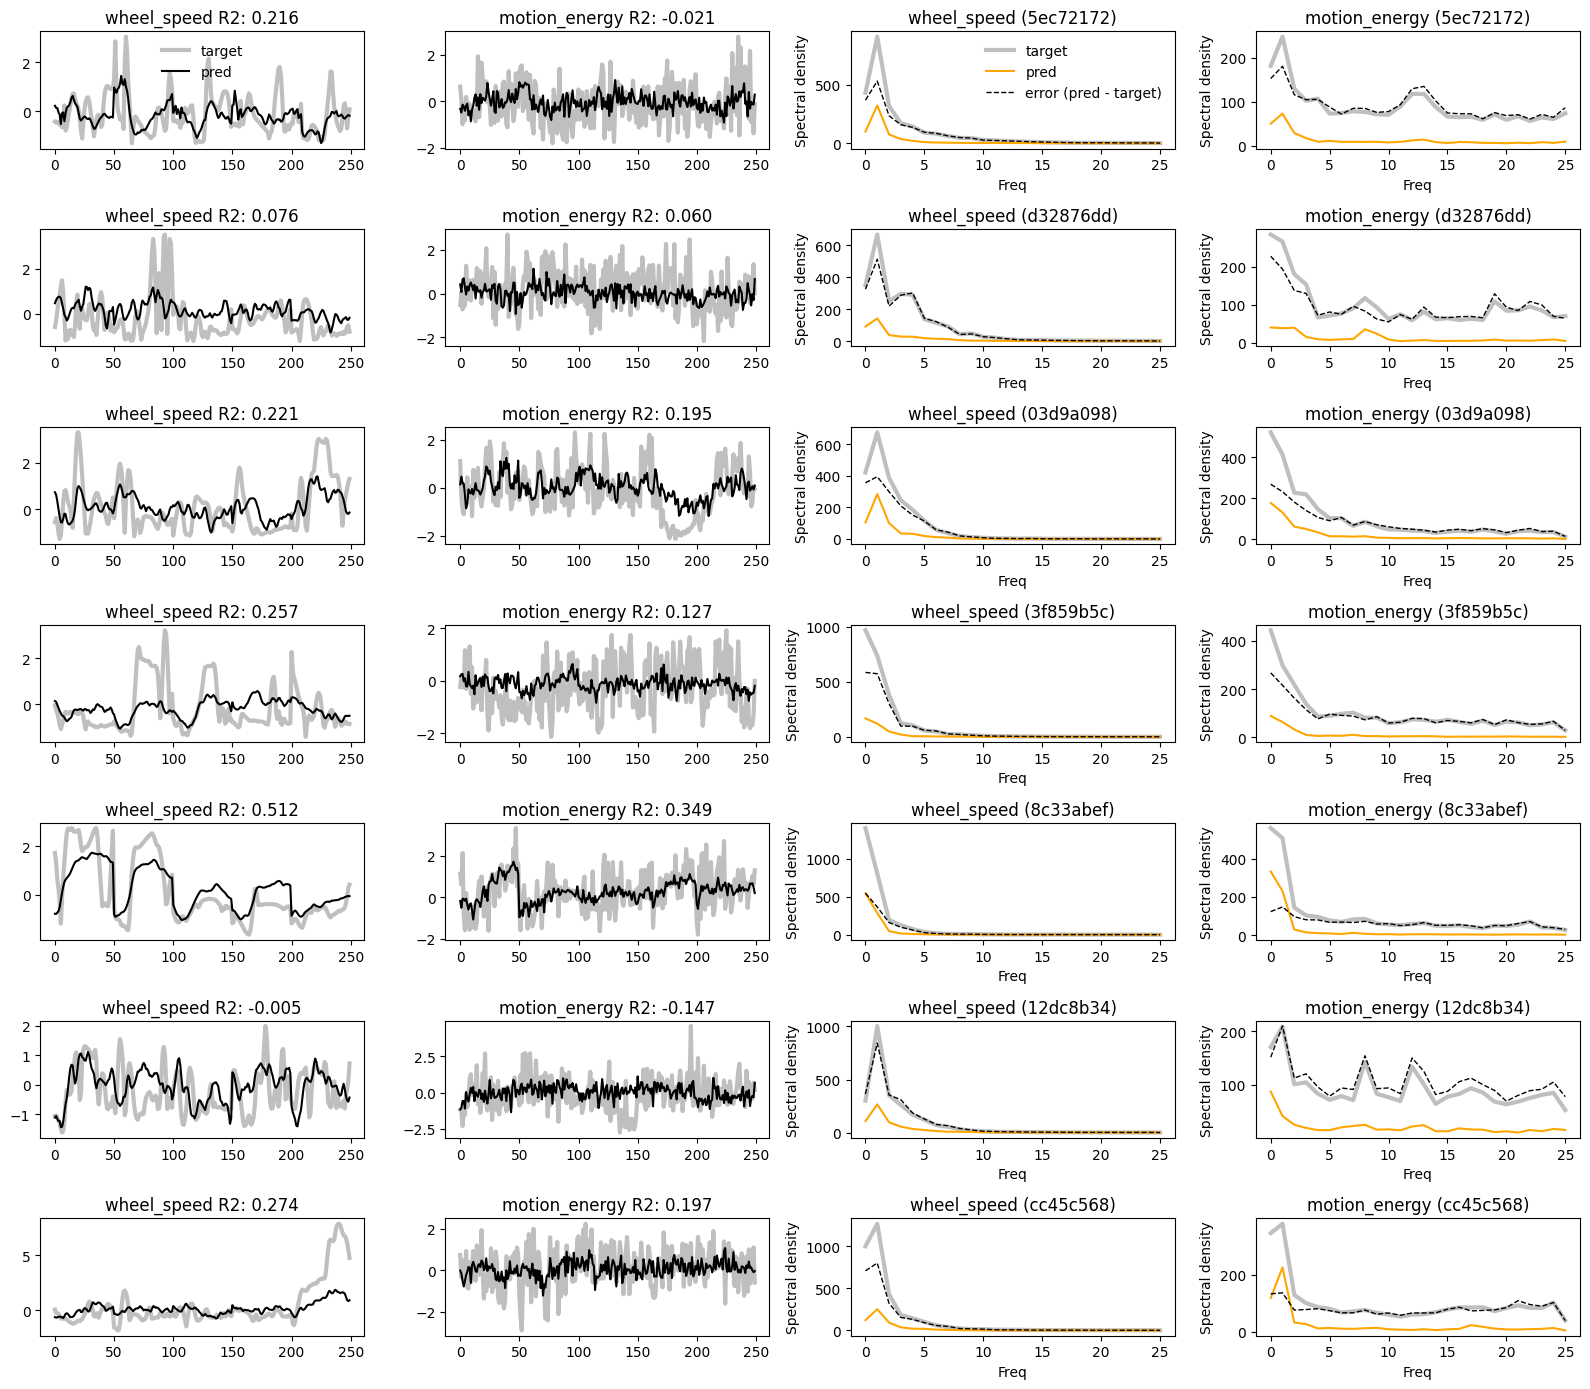

In [200]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+2, figsize=(4*len(targets)*2, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='Fourier'
        )
        axes[i,j].plot(test_y[:5].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:5].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('Freq')
        axes[i,j+2].set_ylabel('Spectral density')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)
            
plt.tight_layout()
plt.savefig('../results/plots/fourier_behavior_decomp.png', dpi=200)